In [1]:
import argparse
import json
from pathlib import Path
from pprint import pprint

import torch
import pandas as pd
import torch.optim as optim
from allennlp.data.vocabulary import Vocabulary
from allennlp.training.trainer import Trainer
from allennlp.data.iterators import BucketIterator
from allennlp.common.util import dump_metrics

from adat.models import Task, get_model_by_name
from adat.dataset import (
    ClassificationReader,
    CopyNetReader,
    LevenshteinReader,
    LanguageModelingReader,
    END_SYMBOL,
    START_SYMBOL
)
from adat.masker import get_default_masker
from adat.utils import load_weights

In [2]:
reader = LanguageModelingReader()

In [3]:
path = 'experiments/lm_models/ag_news/best.th'
vocab_path = 'experiments/lm_models/ag_news/vocab'
task = 'lm'

In [4]:
vocab = Vocabulary.from_files(vocab_path)

In [5]:
model = get_model_by_name(
    task,
    vocab=vocab)

In [6]:
load_weights(model, path)

In [10]:
results = pd.read_csv('results/ag_news/cascada/20200220_160443/results.csv')

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from adat.utils import calculate_perplexity

Text(0, 0.5, 'adv perplexity')

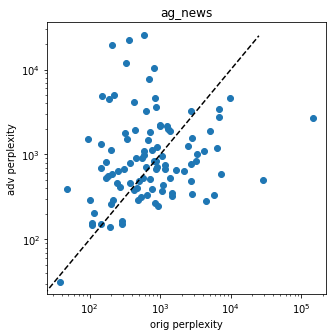

In [20]:
plt.figure(figsize=(5, 5))
plt.title('ag_news')
plt.scatter(calculate_perplexity(results['sequence'].values, model, reader),
            calculate_perplexity(results['adversarial_sequence'].values, model, reader))
plt.plot([0, 25000], [0, 25000], linestyle='--', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('orig perplexity')
plt.ylabel('adv perplexity')

In [21]:
np.log(calculate_perplexity(results['sequence'].values, model, reader))

NameError: name 'np' is not defined

In [6]:
import pandas as pd
import numpy as np

In [16]:
pd.set_option('max_colwidth', 90)

In [4]:
hf = pd.read_csv('results/ag_news/hotflip/20200219_234929/results.csv')

In [19]:
ca = pd.read_csv('results/ag_news/cascada/20200220_110214/results.csv')

In [33]:
indexes = np.random.randint(0, min(hf.shape[0], ca.shape[0]), size=10)
hff = hf.iloc[indexes][['sequence', 'adversarial_sequence']]
caa = ca.iloc[indexes][['sequence', 'adversarial_sequence']]
df = pd.DataFrame.from_dict(
    {
        'sequence': hff['sequence'],
        'hotflip': hff['adversarial_sequence'], 
        'cascada': caa['adversarial_sequence']
    }
)

df

,sequence,hotflip,cascada
97,wall street treads water as traders await fresh direction,wall street treads water as traders await fresh ap,wall street treads water as troops await fresh direction
49,photo may be first of extrasolar planet,photo may be first of extrasolar arafat,photo may be first of excuse rout
98,federal judge orders soldier back to iraq,microsoft internet orders soldier back to iraq,federal judge orders soldier back to \
86,second bomb threat plane lands safely,second bomb threat plane lands nasa,second car threat plane lands safely
0,belgians find canadian jokes about them less than flattering canadian press,nasa find canadian jokes about them less than flattering canadian press,mantech find bryant with them less than anthony canadian press
36,sri lanka beat pakistan in faisalabad test afp,nba lanka beat pakistan in faisalabad test afp,best lanka beat argentina in exploit coach afp
95,indias most wanted bandit killed in shootout reuters,nasa most wanted bandit killed in shootout nasa,indias most was bandit killed in environment auction reuters reuters
40,gt eye on stocks,washingtonpostcom eye on stocks,gt eye on sharon
86,second bomb threat plane lands safely,second bomb threat plane lands nasa,second car threat plane lands safely
23,blair reasserts control after rocky summer ap,blair internet control after rocky summer ap,blair detects control after outer ages


In [1]:
import argparse
from pathlib import Path
import csv
from tqdm import tqdm
from datetime import datetime

import pandas as pd
import torch
from allennlp.data.vocabulary import Vocabulary
from allennlp.common.util import dump_metrics

from adat.models import get_model_by_name
from adat.dataset import CopyNetReader, IDENTITY_TOKEN
from adat.attackers import AttackerOutput, Cascada
from adat.utils import load_weights, get_args_from_path

In [2]:
classifier_path = 'experiments/ag_news/classifier_masked_copynet_with_attention/'
copynet_path = 'experiments/ag_news/masked_copynet_with_attention/'
levenshtein_path = 'experiments/ag_news/deep_levenshtein_masked_copynet_with_attention/'

In [3]:
reader = CopyNetReader(masker=None)

copynet_vocab = Vocabulary.from_files(Path(copynet_path) / 'vocab')
copynet_model_args = get_args_from_path(Path(copynet_path) / 'args.json')
copynet_model = get_model_by_name(
    **copynet_model_args,
    vocab=copynet_vocab,
    beam_size=3
)
load_weights(copynet_model, Path(copynet_path) / 'best.th')

class_model_args = get_args_from_path(Path(classifier_path) / 'args.json')
class_model = get_model_by_name(
    **class_model_args,
    vocab=copynet_vocab,
    copynet=copynet_model
)
load_weights(class_model, Path(classifier_path) / 'best.th')

deep_levenshtein_model_args = get_args_from_path(Path(levenshtein_path) / 'args.json')
deep_levenshtein_model = get_model_by_name(
    **deep_levenshtein_model_args,
    vocab=copynet_vocab,
    copynet=copynet_model
)
load_weights(deep_levenshtein_model, Path(levenshtein_path) / 'best.th')

In [4]:
sample = 1000
data = pd.read_csv('data/ag_news/test.csv')
sequences = data['sequences'].tolist()[:sample]
labels = data['labels'].tolist()[:sample]
maskers = [IDENTITY_TOKEN.split(',')] * len(sequences)

In [5]:
for seq, lab, mask_tokens in tqdm(zip(sequences, labels, maskers)):
    break

0it [00:00, ?it/s]


In [11]:
attacker = Cascada(
    vocab=copynet_vocab,
    reader=reader,
    classification_model=class_model,
    masked_copynet=copynet_model, deep_levenshtein_model=deep_levenshtein_model,
    levenshtein_weight=5.0,
    prob_diff_weight=2.0,
    learning_rate=0.5,
    num_updates=3,
    num_labels=class_model_args['num_classes'],
    device=2
)

In [12]:
attacker.set_input(sequence=seq, mask_tokens=mask_tokens)
attacker.set_label_to_attack(lab)

output = attacker.sample_until_label_is_changed(
    max_steps=30,
    early_stopping=False
)

In [13]:
attacker.empty_history()

In [14]:
output

AttackerOutput(sequence=' belgians find canadian jokes about them less than flattering canadian press', label=0, adversarial_sequence='quotnight find canadian submariners about them less than everton canadian press', adversarial_label=1, wer=3, prob_diff=0.5655502676963806, acceptance_probability=None)

In [10]:
output

AttackerOutput(sequence=' belgians find canadian jokes about them less than flattering canadian press', label=0, adversarial_sequence='mantech find canadian far about them than jailed canadian press', adversarial_label=1, wer=4, prob_diff=0.5608293414115906, acceptance_probability=None)

In [19]:
torch.rand(1, 2)

tensor([[0.6052, 0.3828]])

In [18]:
torch.rand(1, 2) * torch.tensor([0., 1.])

tensor([[0.0000, 0.4937]])

In [20]:
0.99 * 0.5

0.495